In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### **Sentiment Analysis**

In [2]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/NLPFinal/new_train_f.csv')
df.head()

,Rating,Review
0,3,Gave this to my dad for a gag gift after direc...
1,5,I hope a lot of people hear this cd. We need m...
2,5,I'm reading a lot of reviews saying that this ...
3,4,The music of Yasunori Misuda is without questi...
4,5,Probably the greatest soundtrack in history! U...


In [3]:
# Perform text preprocessing
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join the tokens back into a single string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [6]:
df['cleaned_review'] = df['Review'].apply(clean_text)

In [7]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.8 MB/s eta 0:00:00


In [8]:
pip install xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 11.0 MB/s eta 0:00:00


In [9]:
import pandas as pd
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# Define the model and tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the sentiment analysis pipeline with the specified model
sentiment_model = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Create a subset of the DataFrame with the first 10,000 records
subset_df = df.head(1000)

# Perform sentiment analysis on each review in the subset DataFrame
sentiments = []
for review in subset_df['cleaned_review']:
    sentiment = sentiment_model(review)[0]
    sentiments.append(sentiment['label'])

# Add the predicted sentiment labels to the subset DataFrame using .loc accessor
subset_df.loc[:, 'predicted_sentiment'] = sentiments

# Create a new DataFrame to display the results
results_df = pd.DataFrame({
    'Review': subset_df['cleaned_review'],
    'Predicted Sentiment': subset_df['predicted_sentiment']
})
results_df.head()

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
<ipython-input-9-8ae955b13ac2>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.loc[:, 'predicted_sentiment'] = sentiments


,Review,Predicted Sentiment
0,gave dad gag gift directing nunsense got reall...,POSITIVE
1,hope lot people hear cd need strong positive v...,POSITIVE
2,im reading lot review saying best game soundtr...,NEGATIVE
3,music yasunori misuda without question close s...,POSITIVE
4,probably greatest soundtrack history usually b...,POSITIVE


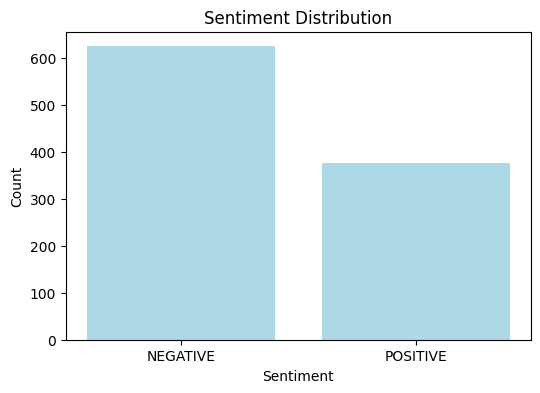

In [13]:
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment label
sentiment_counts = results_df['Predicted Sentiment'].value_counts()

# Create a bar graph to visualize sentiment distribution
plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts.index, sentiment_counts.values, color='lightblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()


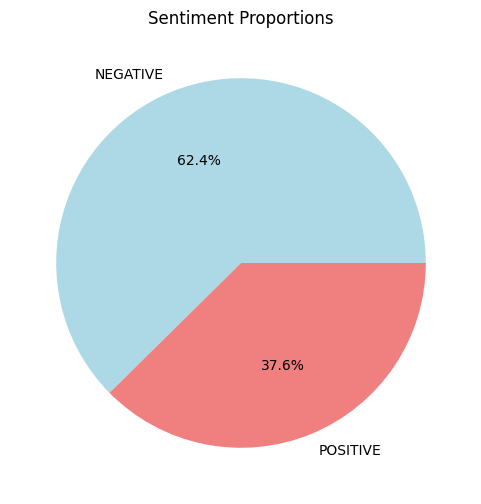

In [14]:
# Create a pie chart to visualize sentiment proportions
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Sentiment Proportions')
plt.show()


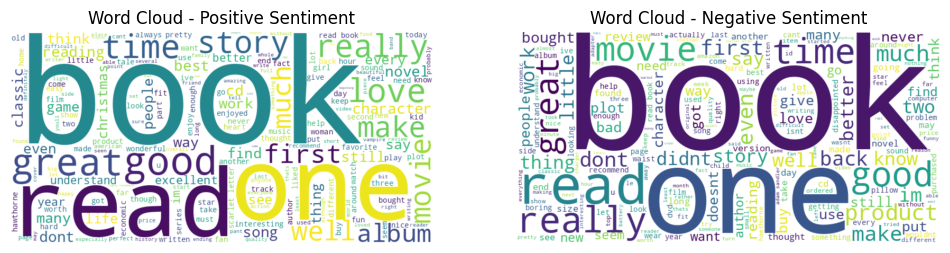

In [15]:
from wordcloud import WordCloud

# Separate positive and negative sentiment reviews
positive_reviews = results_df[results_df['Predicted Sentiment'] == 'POSITIVE']['Review']
negative_reviews = results_df[results_df['Predicted Sentiment'] == 'NEGATIVE']['Review']

# Generate word clouds for positive and negative sentiment reviews
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews))
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_reviews))

# Plot the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Sentiment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Sentiment')
plt.axis('off')

plt.show()


## **Named Entity Recognization**

In [16]:
import pandas as pd
import spacy

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

# Read the CSV file into a pandas DataFrame
dataset = pd.read_csv('/content/drive/MyDrive/NLPFinal/new_train_f.csv')

# Select the first 10 documents
subset = dataset['Review'].head(10)

# Create a new DataFrame to store the named entities
entities_df = pd.DataFrame(columns=['Document', 'Named Entity', 'Category'])

# Apply NER on each selected document and store the results in the DataFrame
for i, review in enumerate(subset):
    doc = nlp(review)
    entities = []
    categories = []
    for entity in doc.ents:
        entities.append(entity.text)
        categories.append(entity.label_)
    data = {'Document': [f"Document {i+1}"] * len(entities),
            'Named Entity': entities,
            'Category': categories}
    entities_df = pd.concat([entities_df, pd.DataFrame(data)], ignore_index=True)

# Display the DataFrame with named entities
entities_df.head(20)

,Document,Named Entity,Category
0,Document 3,Yasunori Mitsuda's,PERSON
1,Document 3,years,DATE
2,Document 3,every penny,MONEY
3,Document 4,Yasunori Misuda,PERSON
4,Document 4,second,ORDINAL
5,Document 4,Nobuo Uematsu,PERSON
6,Document 4,Chrono Cross OST,ORG
7,Document 4,"Scars Left by Time, The Girl",WORK_OF_ART
8,Document 5,first,ORDINAL
9,Document 5,every penny,MONEY


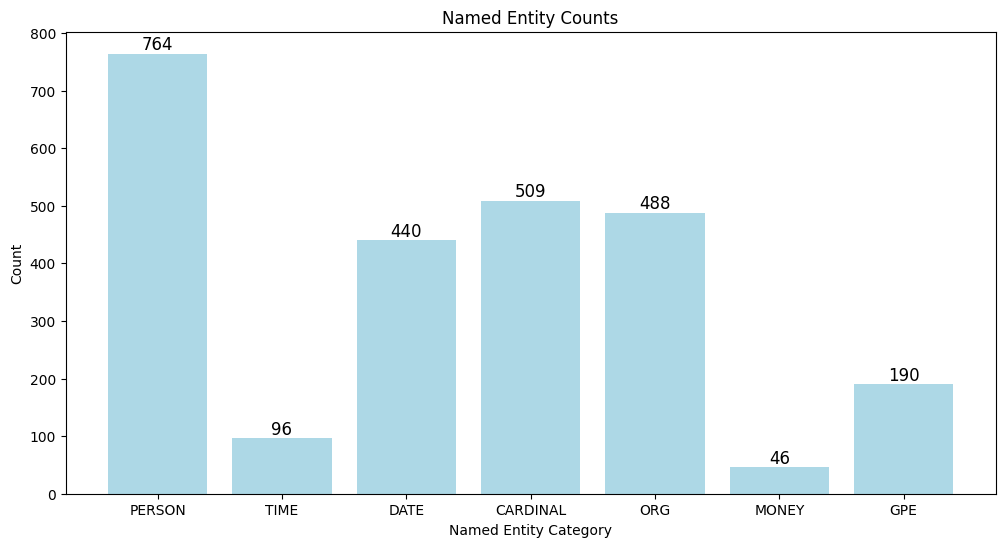

In [17]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

# Read the CSV file into a pandas DataFrame
dataset = pd.read_csv('/content/drive/MyDrive/NLPFinal/new_train_f.csv')

# Select the first 10 documents
subset = dataset['Review'].head(1000)

# Initialize counters for different named entity categories
categories = ['PERSON', 'TIME', 'DATE', 'CARDINAL', 'ORG', 'MONEY', 'GPE']
counts = {category: 0 for category in categories}

# Process each document to extract named entities and their categories
for review in subset:
    doc = nlp(review)
    for entity in doc.ents:
        category = entity.label_
        if category in categories:
            counts[category] += 1

# Prepare data for the bar graph
categories = list(counts.keys())
counts = list(counts.values())

# Create a bar graph to visualize the counts of different named entity categories
plt.figure(figsize=(12, 6))
bars = plt.bar(categories, counts, color='lightblue')
plt.xlabel('Named Entity Category')
plt.ylabel('Count')
plt.title('Named Entity Counts')

# Add values on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(counts[i]), ha='center', va='bottom', fontsize=12)

plt.show()


## **Topic modeling**

In [18]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/NLPFinal/new_train_f.csv')

# Select the first 15 records and create a copy of the DataFrame
df_first_15 = df.head(15).copy()

# Define the topics
topics = [
    "Product Quality",
    "Customer Service",
    "Shipping and Delivery",
    "Price and Value",
    "Product Features and Specifications",
    "Ease of Use",
    "Product Performance",
    "Compatibility and Interoperability",
    "User Experience",
    "Product Comparisons",
    "Product Recommendations",
    "Packaging and Presentation",
    "Returns and Refunds",
    "Product Complaints",
    "Product Praises and Positive Experiences"
]

# Preprocess the text data
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_first_15['Review'])

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
lda = LatentDirichletAllocation(n_components=len(topics), random_state=42)
lda.fit(X)

# Print the top words for each topic
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

# Assign the most probable topic to each document
topic_predictions = lda.transform(X)
df_first_15['Topic'] = topic_predictions.argmax(axis=1)
df_first_15['Topic'] = df_first_15['Topic'].apply(lambda x: topics[x])

# Create a dataframe with the Review and Topic columns
df_output = df_first_15[['Review', 'Topic']]

# Print the dataframe
df_output.head(5)


Topic 1: read, book, say, reviews, cover, waste, maybe, cd, time, don
Topic 2: book, kind, thing, ms, haddon, far, reading, evening, joke, term
Topic 3: day, listen, import, track, version, reason, expensive, minute, best, cd
Topic 4: actually, pair, stockings, disappointed, pathetic, totally, add, typographical, embarrassed, absolutely
Topic 5: chart, sizes, tried, sheer, internet, item, recomended, smaller, check, guess
Topic 6: excellent, states, feet, care, package, shifts, loose, longer, long, tight
Topic 7: read, say, book, love, faults, today, dissapointed, couldn, spend, gives
Topic 8: read, book, say, reviews, cover, waste, maybe, cd, time, don
Topic 9: soundtrack, music, penny, worth, game, ost, tracks, scars, left, yasunori
Topic 10: read, book, say, reviews, cover, waste, maybe, cd, time, don
Topic 11: sea, resort, zen, right, perfect, cool, pitcher, players, plays, comical
Topic 12: directing, got, reall, dad, gift, gave, nunsense, gag, kick, tunes
Topic 13: read, book, sa

,Review,Topic
0,Gave this to my dad for a gag gift after direc...,Packaging and Presentation
1,I hope a lot of people hear this cd. We need m...,Packaging and Presentation
2,I'm reading a lot of reviews saying that this ...,User Experience
3,The music of Yasunori Misuda is without questi...,User Experience
4,Probably the greatest soundtrack in history! U...,User Experience


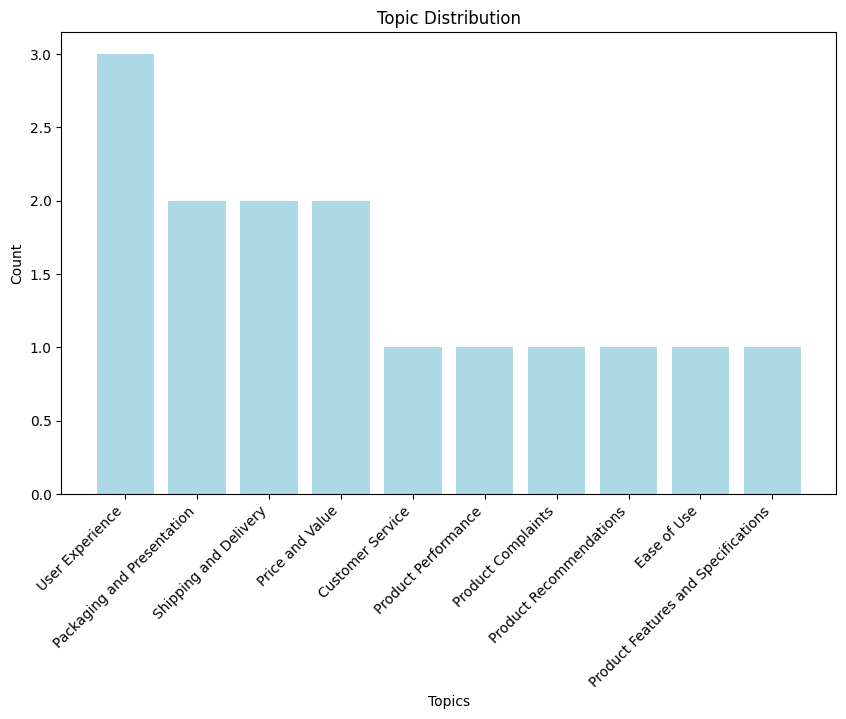

In [19]:
import matplotlib.pyplot as plt

# Count the occurrences of each topic
topic_counts = df_output['Topic'].value_counts()

# Create a bar graph to visualize topic distribution
plt.figure(figsize=(10, 6))
plt.bar(topic_counts.index, topic_counts.values, color='lightblue')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.title('Topic Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()


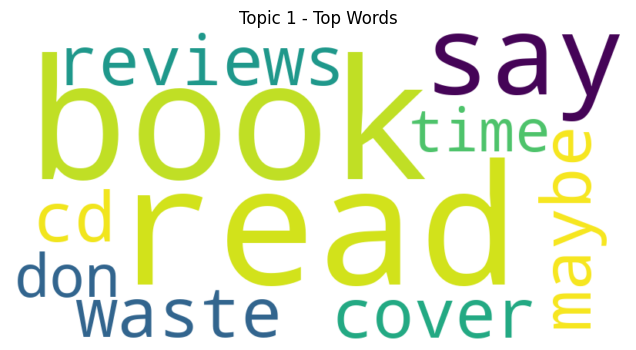

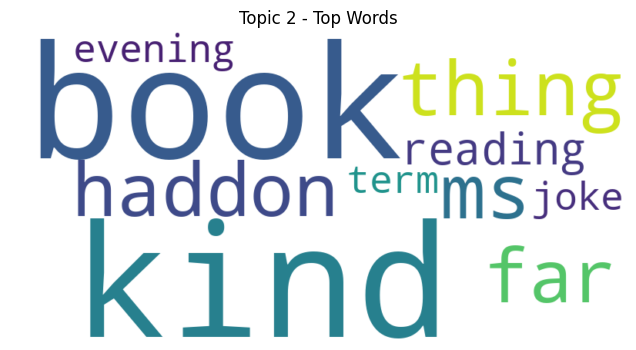

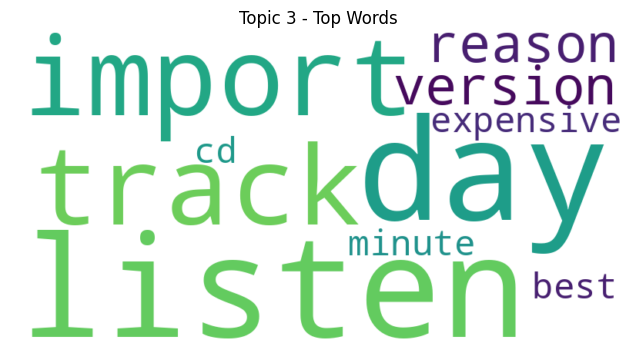

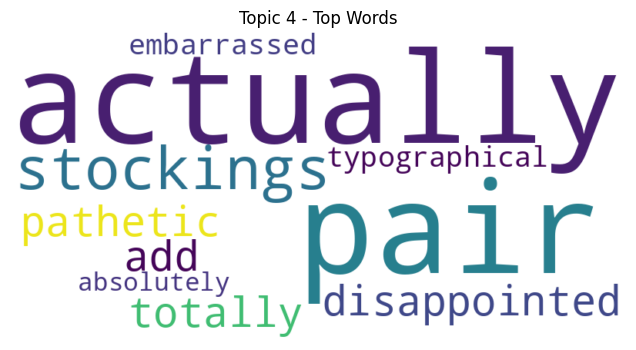

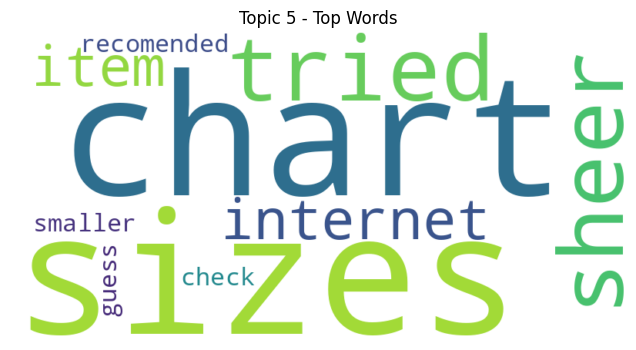

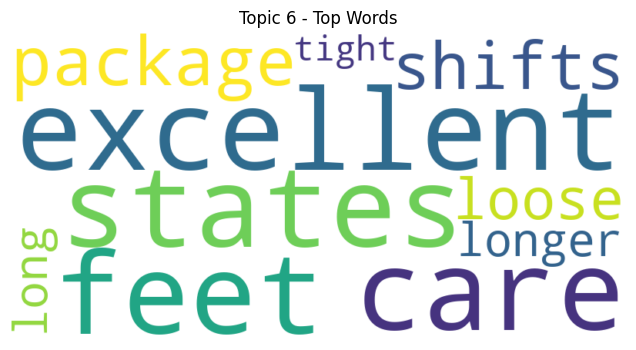

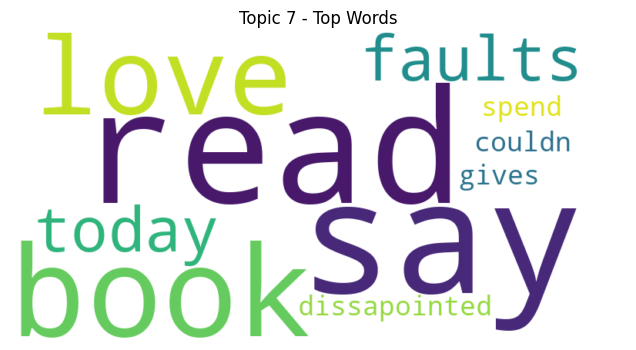

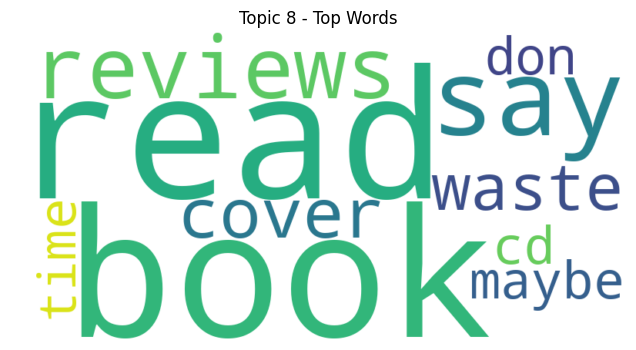

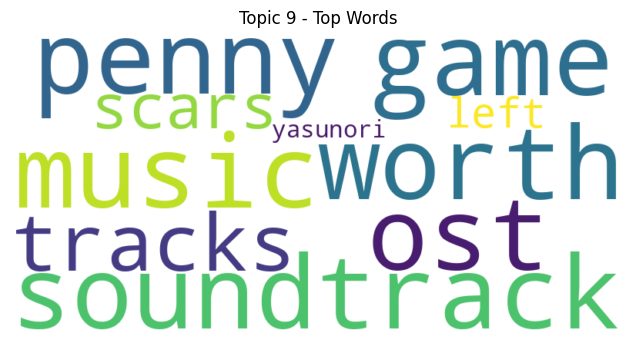

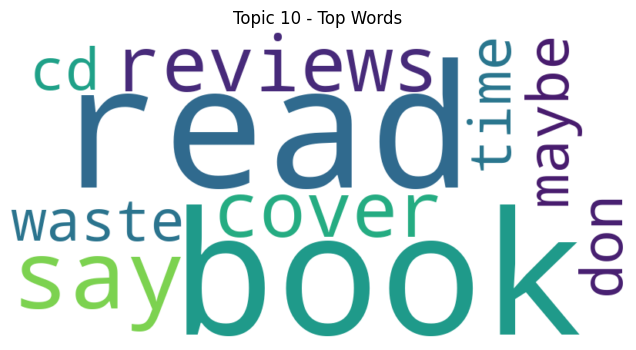

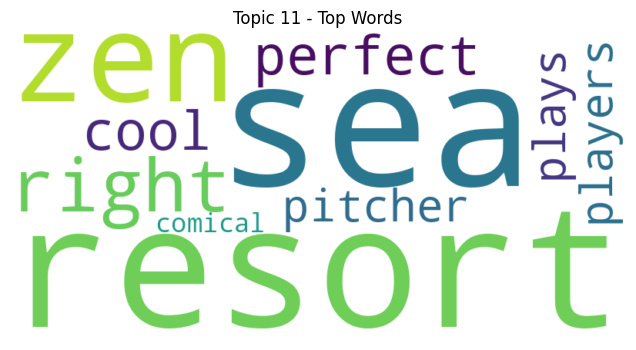

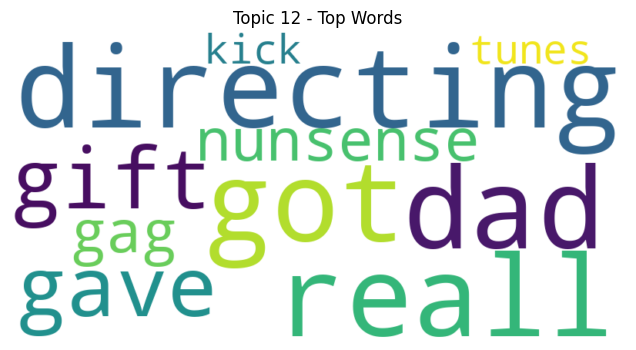

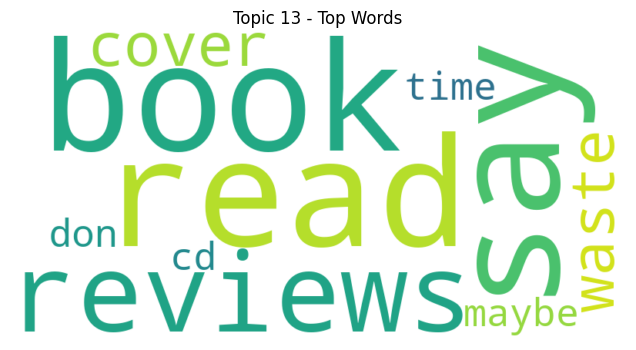

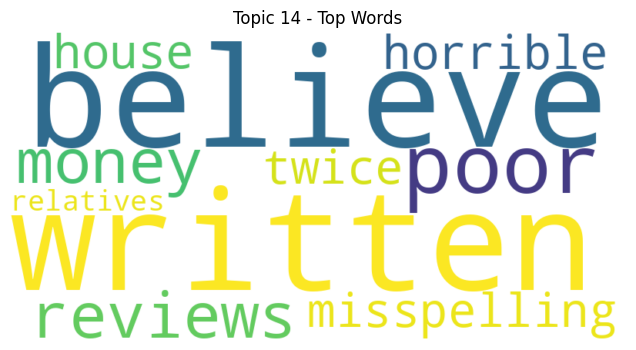

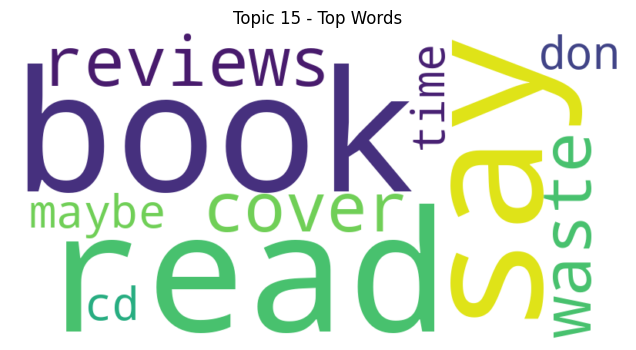

In [20]:
from wordcloud import WordCloud

# Create word clouds for each topic
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_words))
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_idx + 1} - Top Words')
    plt.show()


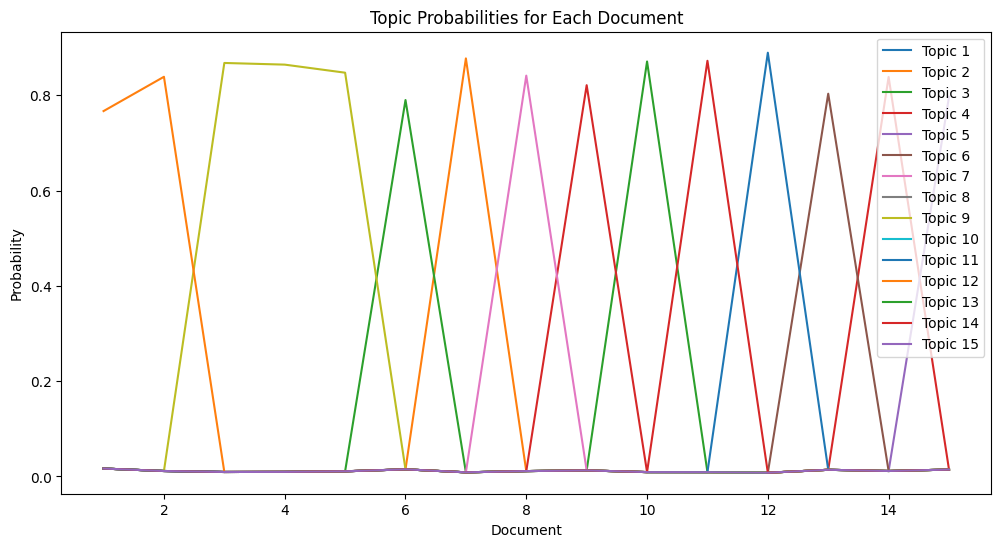

In [21]:
import numpy as np

# Calculate the probabilities of each topic for each document
topic_probabilities = lda.transform(X)

# Create a line plot to visualize the topic probabilities
plt.figure(figsize=(12, 6))
for i in range(len(topics)):
    plt.plot(np.arange(1, 16), topic_probabilities[:, i], label=f"Topic {i + 1}")
plt.xlabel('Document')
plt.ylabel('Probability')
plt.title('Topic Probabilities for Each Document')
plt.legend(loc='upper right')
plt.show()
